# Piece-wise functions in two dimensions with ```pyApproxTools```

In [1]:
import numpy as np
import scipy as sp
import math
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import pyHilbert as hil

%matplotlib inline

```pyApproxTools``` works with an abstraction of the type ```vector```. This abstraction is very simple and all objects of type ```vector``` have the following methods defined

 - __```dot(other)```__, so to calculate $\langle u, v \rangle$ one calls __```u.dot(v)```__
 - __```norm()```__ which actually just calls __```self.dot(self)```__
 - __```evaluate(x)```__ which is completely abstract in that it doens't know anything about what properties of __```x```__ to expect.
 - and standard algebraic operators, i.e. __```+```__, __```-```__, __```*```__ and __```/```__. For now __```*```__ and __```/```__ are only defined between scalars and vectors, hence __```c * v```__ only makes sense if __```c```__ is an __```int```__, __```float```__ or __```complex```__ number.
 
There are essentially only two 2-dimensional piece-wise functions that are supported so far. The are __```PWLinearSqDyadicH1```__ and __```PWConstantSqDyadicL2```__. See __```pyApproxTools/pw_vector.py```__ for their definition and code.

__```PWLinearSqDyadicH1```__ represents piece-wise linear functions on the dyadic subdivided square in $H_0^1([0,1]^2)$. __```PWConstantSqDyadicL2```__ evidently is piece-wise constant in $L^2([0,1]^2)$. The dyadic square, if say our dyadic level is $d$, is divided in to $2^d \times 2^d$ squares. Lets talk a closer look.

### ```PWLinearSwDyadicH1```
This function is on the right-aligned triangulation on the dyadic grid, the function is linear on each triangle. Thus the function is stored as values on the nodes of the grid. There are $(2^d + 1) \times (2^d + 1)$ nodes in the grid, so there are that many values stored. However, since the boundary condition is 0, __```PWLinearSwDyadicH1```__ will automatically set boundary values to 0 if they aren't already.

Below we show what we can do with it, including an in-built plotting routine. Note that the dyadic level $d$ is labelled __```div```__.

[[-0.082978    0.22032449 -0.49988563 -0.19766743 -0.35324411]
 [-0.40766141 -0.31373979 -0.15443927 -0.10323253  0.03881673]
 [-0.08080549  0.1852195  -0.29554775  0.37811744 -0.47261241]
 [ 0.17046751 -0.0826952   0.05868983 -0.35961306 -0.30189851]
 [ 0.30074457  0.46826158 -0.18657582  0.19232262  0.37638915]]


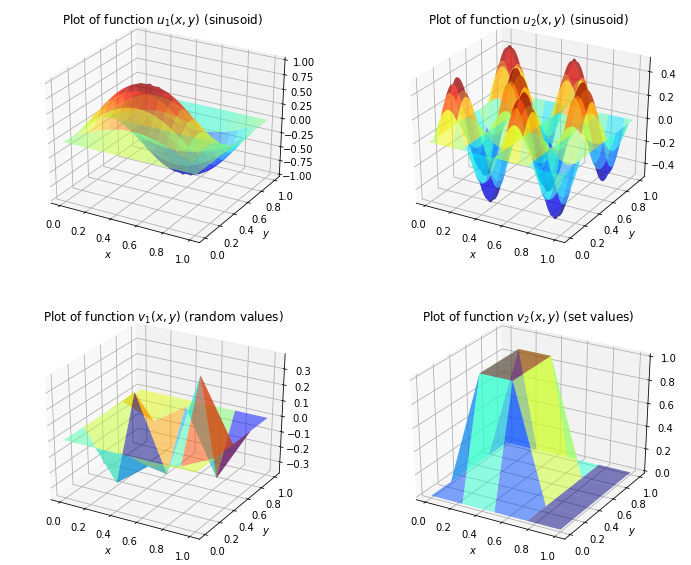

In [2]:
# We can also instantiate a function from any mathematical function, 
# as long as it takes (x, y) as arguments. (this saves a bit of time!)
H1_fine = hil.H1DyadicSq(div=7)

def f_u1(x,y): return np.sin(math.pi * x) * np.sin(2 * math.pi * y)
u1 = H1_fine.vector_from_func(f_u1)

def f_u2(x,y): return 0.5 * np.sin(4 * math.pi * x) * np.sin(3 * math.pi * y)
u2 = H1_fine.vector_from_func(f_u2)

# We can instantiate a function from a specific bunch of values
H1_coarse = hil.H1DyadicSq(div=2)
side_n = H1_coarse.side_len  # The number of non-zero nodes on each side

np.random.seed(1)
v1_vals = np.random.random((H1_coarse.side_len, H1_coarse.side_len)) - 0.5
print(v1_vals)
# THIS WILL GENERATE THE WARNING BELOW AS WE ATTEMPT TO SET THE BOUNDARY TO NON-ZERO VALUES
v1 = hil.Vector(v1_vals.flatten(), space=H1_coarse)

v2_vals = np.zeros((side_n, side_n))
v2_vals[1:4, 1:3] = 1.0
v2 = hil.Vector(v2_vals.flatten(), space=H1_coarse)

# Now we can plot the two. To plot we need to create matplotlib axes 
# (so that we can have some external style control)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
u1.plot(ax, title=r'Plot of function $u_1(x,y)$ (sinusoid)')
ax = fig.add_subplot(2, 2, 2, projection='3d')
u2.plot(ax, title=r'Plot of function $u_2(x,y)$ (sinusoid)')
ax = fig.add_subplot(2, 2, 3, projection='3d')
v1.plot(ax, title=r'Plot of function $v_1(x,y)$ (random values)')
ax = fig.add_subplot(2, 2, 4, projection='3d')
v2.plot(ax, title=r'Plot of function $v_2(x,y)$ (set values)')
plt.show()

...One useful feature implemented is automatic interpolation. If we try and add two functions on mis-matching grid sizes (like the above functions ```u``` and ```v```), the code will match the grids, interpolate, then add, as follows. We can also manually call the interpolation routine.

7 2
w (=u_1+v_1) div is 7, matched to the finer of u's grid (div=7) and v's grid (div=2)


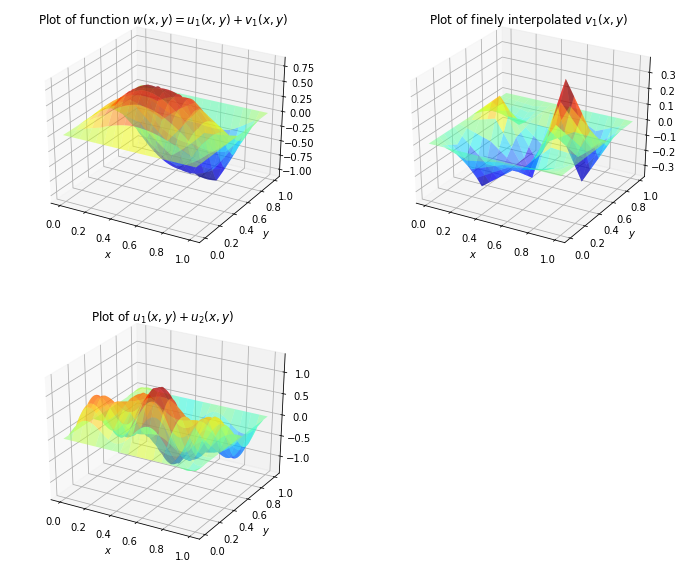

In [3]:
print(u1.space.div, v1.space.div)
w = u1 + v1

print('w (=u_1+v_1) div is {0}, matched to the finer of u\'s grid (div={1}) and v\'s grid (div={2})'.format(w.space.div, u1.space.div, v1.space.div))

v_fine = H1_fine.interp(v1)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
w.plot(ax, title=r'Plot of function $w(x,y)=u_1(x,y)+v_1(x,y)$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
v_fine.plot(ax, title=r'Plot of finely interpolated $v_1(x,y)$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
(u1 + u2).plot(ax, title=r'Plot of $u_1(x,y) + u_2(x,y)$')
plt.show()

### ```PWConstantSqDyadicL2```
Much of the same applies for __```PWConstantSqDyadicL2```__ Now however as there are $2^d$ squares on which the function is piece-wise constant, the object stores $2^d \times 2^d$ values.

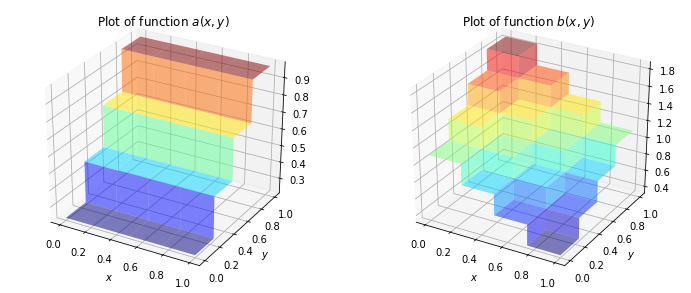

In [4]:
L2 = hil.L2DyadicSq(div=2)

def f_a(x,y): return y + 0.1
a = L2.vector_from_func(func=f_a)

def f_b(x,y): return y - x + 1.1 
b = L2.vector_from_func(func=f_b)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title=r'Plot of function $a(x,y)$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
b.plot(ax, title=r'Plot of function $b(x,y)$')
plt.show()

### Dot products and norms

There is of course the abstraction of dot products. Note that, as we'd hope, the sinusoids are (almost) orthogonal. __```v.norm()```__ simply calls __```sqrt(v.dot(v))```__.

In [8]:
print('dot prod of u1 and u2 = {0}'.format(u1.dot(u2)))
print('dot prod of v2 and u1 = {0}'.format(v2.dot(u1)))
print('dot prod of v1 and v2 = {0}'.format(v1.dot(v2)))

print('norm of u1 = {0}'.format(u1.norm()))
print('dot prod of u1 and u1 = {0}'.format(u1.dot(u1)))

print(v2.dot(u1), u1.dot(v2))


dot prod of u1 and u2 = -4.2869353900076845e-15
dot prod of v2 and u1 = 9.194034422677078e-17
dot prod of v1 and v2 = -1.0099689606213782
norm of u1 = 3.512107630458209
dot prod of u1 and u1 = 12.334900007922776
9.194034422677078e-17 -1.1526044875476149e-14


### Bases
We have the abstraction available to construct a basis and perform typical tasks like orthonormalising and projecting. Lets take two examples of a basis, one randomly generated, the other sinusoid, and see what we can do. Check out __```pyApproxTools/basis.py```__ for details of functions.

Note that the class __```PWBasis```__ is implemented for performance reasons. One can make a basis of piecewise vectors (e.g. of type __```PWLinearSwDyadicH1```__) from the __```Basis```__ class, however __```PWBasis```__ implements the dot products, projects, and multiplications much faster. The class __```PWBasis```__ inherits all functionality from __```Basis```__.

In [ ]:
# Finally have the basis code I've been waiting for:


def sin2d(x,y,n,m): return np.sin(math.pi * n * x) * np.sin(m *math.pi * y)

sin_b = []
for n in range(2):
    for m in range(2):
        sin_b.append(pat.PWLinearSqDyadicH1(func=lambda x,y: np.sin(math.pi * n * x) * np.sin(m * math.pi * y), div=div))
sin_basis = pat.PWBasis(sin_b)

v_test = pat.PWLinearSqDyadicH1(func=lambda x,y: np.sin(math.pi * n * x) * np.sin(m * math.pi * y), div=div)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
print(sin_basis.H @ v1)
(sin_basis @ (sin_basis.H @ v1)).plot(ax)

ax = fig.add_subplot(1, 2, 2, projection='3d')

v1.plot(ax)

### Solving the diffusion equation using FEM

Finally, we have the ability to solve the diffusion equation
$$
- \mathrm{div} (a \nabla u) = f
$$

In [ ]:
fem_div = 7

a_bar = 1.0
c = 0.9
field_div = 2
side_n = 2**field_div

np.random.seed(3)
point_gen = pat.MonteCarlo(d=side_n*side_n, n=1, lims=[-1, 1])
a = pat.PWConstantSqDyadicL2(a_bar + c * point_gen.points[0,:].reshape([side_n, side_n]), div=field_div)
fem = pat.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

u = fem.u

In [ ]:
Vn =  pat.make_pw_sin_basis(4)

print((Vn.G - np.eye(Vn.n)).max())
print(np.linalg.norm(Vn.G - np.eye(Vn.n)))

#print(np.round(Vn.G[:,0], 7))
#print(np.round(Vn.G[:,1], 7))
#print(np.round(Vn.G[:,2], 7))
#print(np.round(Vn.G[:,3], 7))
#print(np.round(Vn.G[:,4], 7))
#print(np.round(Vn.G[:,5], 7))
#print(np.round(Vn.G[:,-1], 7))